In [0]:
%cd /content/drive/My\ Drive/datasets/Netflix/

/content/drive/My Drive/datasets/Netflix


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# PreProcessing

In [0]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['combined_data_1.txt','combined_data_2.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.001279


In [0]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)

#sorting according to time.
df.sort_values(by='date', inplace=True)
print(df.head(5))

creating the dataframe from data.csv file..
          movie    user  rating       date
6901473    1367  510180       5 1999-11-11
30883966   5625  510180       4 1999-11-11
19585852   3730  510180       4 1999-11-11
9056171    1798  510180       5 1999-11-11
46516889   8357  510180       4 1999-11-11


## NAN Check

In [0]:
df.isnull().sum()

movie     0
user      0
rating    0
date      0
dtype: int64

#Removing Duplicates

In [0]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("No. of duplicates in data: ",dups)

No. of duplicates in data:  0


# Total no. of unique count of ratings,users & movies

In [0]:
print("Total data ")
print("-"*10)
print("\nTotal no of unique ratings :",df.shape[0])
print("Total No of unique Users   :", len(np.unique(df['user'])))
print("Total No of unique movies  :", len(np.unique(df['movie'])))

Total data 
----------

Total no of unique ratings : 51031355
Total No of unique Users   : 478018
Total No of unique movies  : 9210


## Splitting data based on time

In [0]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_data = pd.read_csv("train.csv", parse_dates=['date'])
test_data = pd.read_csv("test.csv",parse_dates=['date'])

# Train data statistics

In [0]:
print("Train data ")
print("-"*10)
print("\nTotal no of unique ratings :",train_data.shape[0])
print("Total No of unique Users   :", len(np.unique(train_data['user'])))
print("Total No of unique movies  :", len(np.unique(train_data['movie'])))

Train data 
----------

Total no of unique ratings : 40825084
Total No of unique Users   : 398674
Total No of unique movies  : 9008


# Test data statistics

In [0]:
print("Total data ")
print("-"*10)
print("\nTotal no of unique ratings :",test_data.shape[0])
print("Total No of unique Users   :", len(np.unique(test_data['user'])))
print("Total No of unique movies  :", len(np.unique(test_data['movie'])))

Total data 
----------

Total no of unique ratings : 10206271
Total No of unique Users   : 329395
Total No of unique movies  : 9203


#Exploratory Data Analysis

In [0]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

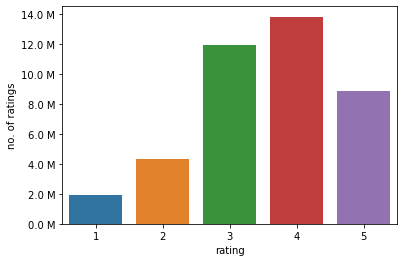

In [0]:
fig, ax = plt.subplots()
sns.countplot(train_data.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.ylabel('no. of ratings')
plt.show()

#Adding new column 'day_of_week'

In [0]:
train_data['day_of_week'] = train_data.date.dt.weekday_name
train_data.head(5)

,movie,user,rating,date,day_of_week
0,1367,510180,5,1999-11-11,Thursday
1,5625,510180,4,1999-11-11,Thursday
2,3730,510180,4,1999-11-11,Thursday
3,1798,510180,5,1999-11-11,Thursday
4,8357,510180,4,1999-11-11,Thursday


# Number of Ratings per a month

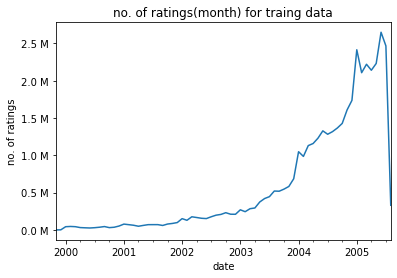

In [0]:
ax=train_data.resample('m' ,on='date')['rating'].count().plot()
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.title('no. of ratings(month) for traing data')
plt.ylabel('no. of ratings')
plt.show()


## Number of movie Ratings given by user

In [0]:
no_of_rated_movies_per_user = train_data.groupby('user')['rating'].count().sort_values(ascending=False)
print(no_of_rated_movies_per_user.head(5))
print('_'*20)
print(no_of_rated_movies_per_user.describe())

user
305344     8868
2439493    8174
387418     7968
1639792    5101
1461435    4817
Name: rating, dtype: int64
____________________
count    398674.000000
mean        102.402173
std         150.371995
min           1.000000
25%          17.000000
50%          46.000000
75%         127.000000
max        8868.000000
Name: rating, dtype: float64


In [0]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

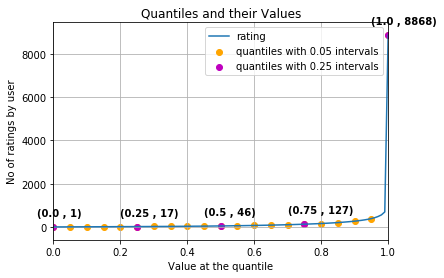

In [0]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.grid()
plt.show()

In [0]:
quantiles[::5]

0.00       1
0.05       4
0.10       7
0.15      10
0.20      13
0.25      17
0.30      21
0.35      25
0.40      31
0.45      38
0.50      46
0.55      57
0.60      69
0.65      84
0.70     103
0.75     127
0.80     159
0.85     202
0.90     268
0.95     387
1.00    8868
Name: rating, dtype: int64

In [0]:
print('no. of user ratings >387 : ',sum(no_of_rated_movies_per_user>=387))

no. of user ratings >387 :  19946


## No. of ratings given for movie by users

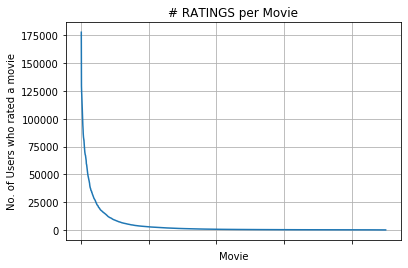

In [0]:
no_of_ratings_per_movie = train_data.groupby('movie')['rating'].count().sort_values(ascending=False)

ax = plt.gca() #getCurrentAxis
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No. of Users who rated a movie')
plt.grid()
ax.set_xticklabels([])

plt.show()

1.There are some movies (which are very popular) which are rated by huge  more number of users.<br>
2.most of the movies have some hundereds of ratings.

#Number of ratings per each day in week

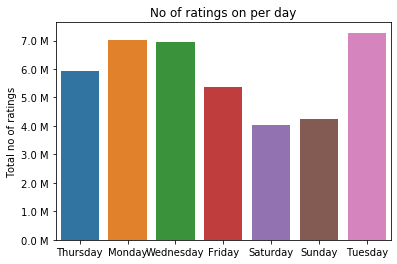

In [0]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_data, ax=ax)
plt.title('No of ratings on per day')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [0]:
avg_week_data = train_data.groupby('day_of_week')['rating'].mean()
print(" Average ratings per day")
print("-"*20)
print(avg_week_data)


 Average ratings per day
--------------------
day_of_week
Friday       3.572173
Monday       3.567473
Saturday     3.583005
Sunday       3.582832
Thursday     3.572752
Tuesday      3.565787
Wednesday    3.575152
Name: rating, dtype: float64


 'day_of_week' feature is not a significant feature as Average no. of ratings are almost same for all days in a week.

## Creating sparse matrix from data

In [0]:
from scipy.sparse import csr_matrix,save_npz,load_npz
#for train_data
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    print("using previously created sparse matrix ")
    # just get it from the disk instead of computing it
    train_sparse_matrix = load_npz('train_sparse_matrix.npz')
else: 
    print("creating sparse_matrix from the train_data")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = csr_matrix((train_data.rating.values, (train_data.user.values,
                                               train_data.movie.values)),)
    
    print(' shape of train_sparse_matrix: (user, movie) : ',train_sparse_matrix.shape)
    # save it into disk
    save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

using previously created sparse matrix 
0:00:02.175291


In [0]:
users,movies = train_sparse_matrix.shape
elemnts = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elemnts/(users*movies))) * 100) )

Sparsity Of Train matrix : 99.83271081896056 % 


In [0]:
#for test_data
start = datetime.now()
if os.path.isfile('test_sparse_matrix.npz'):
    print("using previously created sparse matrix ")
    # just get it from the disk instead of computing it
    test_sparse_matrix = load_npz('test_sparse_matrix.npz')
else: 
    print("creating sparse_matrix from the test_data")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = csr_matrix((test_data.rating.values, (test_data.user.values,
                                               test_data.movie.values)),)
    
    print(' shape of test_sparse_matrix: (user, movie) : ',test_sparse_matrix.shape)
    # save it into disk
    save_npz("test_sparse_matrix.npz", test_sparse_matrix)
    print('Done')

print(datetime.now() - start)

using previously created sparse matrix 
0:00:00.600690


In [0]:
users,movies = test_sparse_matrix.shape
elemnts = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elemnts/(users*movies))) * 100) )

Sparsity Of Test matrix : 99.95817770474015 % 


# Average of all movie ratings, Average rating per user, and Average rating per movie

In [0]:
def get_average_ratings(sparse_matrix, users):
    
    # average ratings of user/axes
    if users:
      ax=1 #User axis
    else:
      ax=0 #Movie axis

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user rated OR movie rated
    no_of_ratings = is_rated.sum(axis=ax).A1
    print(no_of_ratings)
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users/ Movies and their average ratigns
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [0]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5729978412291814}

In [0]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


train_averages['movie'] =  get_average_ratings(train_sparse_matrix, users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])

[  0   0   0 ...   0   0 129]

Average rating of user 10 : 3.282828282828283
[    0   394   104 ... 15658   110  1600]

 AVerage rating of movie 15 : 3.3038461538461537


# Cold Start problem with Users

In [0]:

total_users = len(np.unique(df['user']))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 478018

Number of Users in Train data : 398674

No of Users that didn't appear in train data: 79344(16.6 %) 
 


# Cold Start problem with Movies

In [0]:

total_movies = len(np.unique(df['movie']))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 9210

Number of Users in Train data : 9008

No of Movies that didn't appear in train data: 202(2.19 %) 
 


## Computing User-User Similarity matrix

In [0]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
  
    no_of_users, no_of_movies = sparse_matrix.shape
    # get the indices of  non zero rows(users) from our sparse matrix
    
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind=sorted(set(row_ind))
    print(row_ind)

    time_taken = list() #  time taken for finding similar users for an user..
    
    # we create rows, cols, and data lists.which can be used to create sparse matrices
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        # get the similarity row for this user with all other users
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        # We will get only the top ''top'' most similar users and ignore rest of them..
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        # add them to our rows, cols and data
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    # lets create sparse matrix out of these and return it
    if verbose: print('Creating Sparse matrix from the computed similarities')
    #return rows, cols, data
    
    return csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

In [0]:
from datetime import datetime

start = datetime.now()
u_u_sim_sparse = compute_user_similarity(train_sparse_matrix, compute_for_few=True, top = 100,
                                                     verbose=True)
print("-"*100)
print("Time taken :",datetime.now()-start)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



computing done for 20 users [  time elapsed : 0:00:30.017825  ]
computing done for 40 users [  time elapsed : 0:01:01.127044  ]
computing done for 60 users [  time elapsed : 0:01:30.327670  ]
computing done for 80 users [  time elapsed : 0:01:59.569061  ]
computing done for 100 users [  time elapsed : 0:02:29.053428  ]
Creating Sparse matrix from the computed similarities
----------------------------------------------------------------------------------------------------
Time taken : 0:02:34.557544


*users*  -  *Time Taken To calculaate U_U_sim_matrix* <br>
 100     -   2.29 Minutes<br>
 398674  -   9,129.63 Minutes => 152.16 hrs => 6.34 days  <br>

 lets try reducing deimensinality of User-Movie Matrix 
 using TruncatedSVD to reduce calculation time U_U_sim_matrix


In [0]:

from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

# initilaize the algorithm with some parameters..
# All of them are default except n_components. n_itr is for Randomized SVD solver.
netflix_svd = TruncatedSVD(n_components=500, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_sparse_matrix)

print(datetime.now()-start)

KeyboardInterrupt: ignored

In [0]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)
ind = [1, 2,4,8,20, 60, 100, 200, 300, 400, 500]

for i in ind:
    print("({}, {})".format(i, np.round(expl_var[i-1], 2)))

In [0]:
# Let's project our Original U_M matrix into into 500 Dimensional space
print('netflix_svd.components_ shape:',netflix_svd.components_.shape)
start = datetime.now()
trunc_matrix = train_sparse_matrix.dot(netflix_svd.components_.T)
print(datetime.now()- start)

In [0]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    # create that sparse sparse matrix
    trunc_sparse_matrix = csr_matrix(trunc_matrix)
    # Save this truncated sparse matrix for later usage..
    save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = load_npz('trunc_sparse_matrix.npz')

In [0]:
start = datetime.now()
trunc_u_u_sim_matrix = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)
print("-"*50)
print("time:",datetime.now()-start)

# Computing Movie-Movie Similarity Matrix

In [0]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Saving it to disk")
else:
    print("Reading from disk")
    m_m_sim_sparse = load_npz("m_m_sim_sparse.npz")

print("m_m_sim_sparse.shape : ",m_m_sim_sparse.shape)

print(datetime.now() - start)

Saving it to disk
m_m_sim_sparse.shape :  (9211, 9211)
0:02:37.739226


In [0]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[5]

0:07:55.356367
[3404 6602 3410 ... 3845 3853    0]


array([5138, 8747, 3175, 4313,   92, 3939, 5381,   91, 3450, 5189, 5772,
       5057, 3018, 5892, 2839, 1997, 5081,   69, 8144, 2608, 7862, 4142,
       4768, 6714, 8959, 3327, 5834, 7949, 1958, 8876, 3839, 7087, 8642,
       4592, 8442, 9038, 3057, 7944, 1138, 4864,  617, 7580,  223, 5736,
       7566, 2700,  290, 2992, 3138, 5363, 5401, 2475, 3274, 3161, 7635,
        133, 7521, 6315, 3225, 8298, 4384, 4310, 8563, 3713, 1668, 2136,
       4402, 1728, 6237, 3526, 7879, 5636, 2173,  191, 8811,  751, 5103,
        457, 4843, 1509, 2172, 1665, 7963, 5406, 5448, 6205, 8336, 3046,
       8764, 2186, 2376, 8535, 7511, 6833, 8627, 7414, 7125, 4829, 5582,
        417])

In [0]:
movie_names = pd.read_csv('movie_titles.csv', sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_names.head()


Tokenization took: 3.24 ms
Type conversion took: 12.56 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [0]:
print('Movies similar to \'{}\''.format(movie_names.loc[5]['title']))
movie_names.loc[similar_movies[5][:10]]


Movies similar to 'The Rise and Fall of ECW'


,year_of_release,title
movie_id,,
5138,2004.0,WWE: Hard Knocks: The Chris Benoit Story
8747,2001.0,ECW: Hardcore History
3175,2000.0,ECW: Path of Destruction
4313,2001.0,ECW: The Best of the Dudley Boyz
92,2002.0,ECW: Cyberslam '99
3939,2001.0,ECW: Heatwave '98
5381,2002.0,ECW: Guilty as Charged 2001
91,2005.0,WWE: Royal Rumble 2005
3450,2003.0,WWE: Survivor Series 2004
